In [1]:
import numpy as np
from scipy.misc import factorial
import pylab as pl

### Define parameters

In [2]:
Nt = 400 # number of time points
k = 8
dtime = 0.001

### Create supported dimension

In [3]:
class Support:
    
    def __init__(self, tstr_min=0.10, tstr_max=0.5, buff_len=10, k=8, dtime=0.001):
        self.tstr_min = tstr_min
        self.tstr_max = tstr_max
        self.buff_len = buff_len
        self.k = k
        self.dtime = dtime
        self.len_time = Nt*dtime
        
        self.N = self.buff_len+2*self.k
        self.Nt = int(self.len_time/self.dtime)

        #Create power-law growing Taustarlist and corresponding s
        a = (self.tstr_max/self.tstr_min)**(1./buff_len)-1
        pow_vec = np.arange(-self.k,buff_len + self.k) #-1
        self._Taustarlist = self.tstr_min * (1 + a)**pow_vec

        s = self.k/self._Taustarlist
        
        #Create DerivMatrix
        self._DerivMatrix = np.zeros((self.N,self.N))
        for i in range(1,self.N-1):
            self._DerivMatrix[i, i-1] = -(s[i+1]-s[i])/(s[i]-s[i-1])/(s[i+1] - s[i-1])
            self._DerivMatrix[i, i] = ((s[i+1]-s[i])/(s[i]- s[i-1])-(s[i]-s[i-1])/(s[i+1]-s[i]))/(s[i+1] - s[i-1])
            self._DerivMatrix[i, i+1] = (s[i]-s[i-1])/(s[i+1]-s[i])/(s[i+1] - s[i-1])

        self.t = np.zeros((self.N,self.Nt))
        self.T = np.zeros((self.N,self.Nt))
        self._s = s
        
    def update(self, time_index, f, alpha = 1):
        self.t[:,time_index] = self.t[:,time_index-1]+alpha*((-self._s.T*self.t[:,time_index-1]+f[time_index])*self.dtime)
        t_diff = np.dot(np.linalg.matrix_power(self._DerivMatrix, self.k), self.t[:,time_index])
        L1 = (-1)**self.k*self._s**(self.k+1) # this can be taken out
        L2 = t_diff/factorial(self.k)
        self.T[:,time_index] = L1.T*L2.T

### Create an input node prototype

In [4]:
class input_node:
    
    def __init__(self, name):
        self.name = name
        self.support = Support()
        self.value = np.zeros(Nt)           

### Define input space

In [5]:
input_names = ['a', 'b', 'c']

#cat = input_node() # basic example

# for each input name create an instance of a class input_name with the name of the input
# all input instances are placed in a list called inputs
inputs = []
for name in input_names:
    inputs.append(input_node(name))

### Create an action node prototype

In [6]:
class input_node:
    
    def __init__(self, name):
        self.name = name
        self.support = Support()
        self.value = np.zeros(Nt) 

### Define action space

In [7]:
action_names = ['attend_to_change', 'diff', 'up', 'down','lick']

actions = []
for name in action_names:
    actions.append(input_node(name))

### Create program class

In [8]:
class program:
    
    def __init__(self):
        pass
    
    class dms:
        def __init__(self):
            
            self.alpha = -1 # default is to run the program
            
        def start(self, time_index, k=8):
            
            s = inputs[0].support._s
                        
            actions[action_names.index('attend_to_change')].support.t[:,time_index-1] = \
            dtime*np.exp(-inputs[0].support._Taustarlist[k+1]*s)
            
            actions[action_names.index('attend_to_change')].support.t[:,time_index-1] = \
            actions[action_names.index('attend_to_change')].support.t[:,time_index-1] + \
            dtime*np.exp(-inputs[0].support._Taustarlist[k+2]*s)
                        
            actions[action_names.index('diff')].support.t[:,time_index-1] = \
            dtime*np.exp(-inputs[0].support._Taustarlist[k+3]*s)
            
            actions[action_names.index('up')].support.t[:,time_index-1] = \
            dtime*np.exp(-inputs[0].support._Taustarlist[k+4]*s)
            
            actions[action_names.index('down')].support.t[:,time_index-1] = \
            dtime*np.exp(-inputs[0].support._Taustarlist[k+4]*s)
            
            actions[action_names.index('lick')].support.t[:,time_index-1] = \
            dtime*np.exp(-inputs[0].support._Taustarlist[k+5]*s)
        
        def set_alpha(self, alpha):
            self.alpha = alpha
            
        def play(self, alpha):
            actions[action_names.index('attend_to_change')].support.alpha = alpha
            actions[action_names.index('attend_to_change')].support.alpha = alpha
            actions[action_names.index('diff')].support.alpha = alpha
            actions[action_names.index('up')].support.alpha = alpha
            actions[action_names.index('down')].support.alpha = alpha
            actions[action_names.index('lick')].support.alpha = alpha

### Describe specific actions

In [9]:
# scan through the input space and find a change
# for the moment this just tests if there is a non-zero input
def attend_to_change():
    # pause the program since no input
    dms.set_alpha(0)
    for name in input_names:
        if inputs[input_names.index(name)].value[time_index] > 0:
            # stop decay of the input neuron
            inputs[input_names.index(name)].support.alpha = 0
            # move the program forward (technically backward)
            dms.set_alpha(-1)
            # terminate this function - this is bad since it kills all future calls to this same funciton
            actions[action_names.index('attend_to_change')].support.t[:,time_index] = 0.
            
def diff():
    pass

def up():
    pass

def down():
    pass

def lick():
    pass
    

### Update memory at every time step

In [10]:
def update_input_memory():
    for name in input_names:
        inputs[input_names.index(name)].support.update(time_index, inputs[input_names.index(name)].value)
    
def update_program_memory(alpha):    
    for name in action_names:
        actions[action_names.index(name)].support.update(time_index, np.zeros(Nt), alpha)
        
def check_program_memory():
    for name in action_names:
        if(actions[action_names.index(name)].support.T[k,time_index] >= 0.024): # if reached a peak
            actions[action_names.index(name)].value[time_index] = 1. # made the corresponding action node active
            eval(name+'()') # call the function that nodes is connected with 
                            # this could be solved in a more elegant way if action_names is a dictionary 

### Plot stuff

In [11]:
%matplotlib inline
#%matplotlib notebook
pl.ion()

def plot_inputs():
    for idx, name in enumerate(input_names):
        _ = pl.subplot(len(input_names), 1, idx+1)
        _ = pl.plot(inputs[input_names.index(name)].value, color='blue')
        
def plot_memory():
    k = inputs[0].support.k
    for idx, name in enumerate(input_names):
        _ = pl.subplot(len(input_names), 1, idx+1)
        #_ = pl.scatter(time_index, inputs[input_names.index(name)].support.T[k:-k,time_index], color='blue')
        _ = pl.plot(inputs[input_names.index(name)].support.T[k:-k,:].T, color='blue')
        
        
def plot_inputs_memory():
    fig = pl.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    k = inputs[0].support.k
    for idx, name in enumerate(input_names):
        ax = pl.subplot(3, len(input_names), idx+1)
        ax.set_title(input_names[idx])
        ax.plot(inputs[input_names.index(name)].value, color='blue')
        ax = pl.subplot(3, len(input_names), idx+1+len(input_names))
        ax.plot(inputs[input_names.index(name)].support.t[k:-k,:].T, color='blue')
        ax = pl.subplot(3, len(input_names), idx+1+2*len(input_names))
        ax.plot(inputs[input_names.index(name)].support.T[k:-k,:].T, color='blue')
        
def plot_actions_memory():
    fig = pl.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    k = inputs[0].support.k
    for idx, name in enumerate(action_names):
        ax = pl.subplot(3, len(action_names), idx+1)
        ax.set_title(action_names[idx])
        ax.plot(actions[action_names.index(name)].value, color='blue')
        ax = pl.subplot(3, len(action_names), idx+1+len(action_names))
        ax.plot(actions[action_names.index(name)].support.t[k:-k,:].T, color='blue')
        ax = pl.subplot(3, len(action_names), idx+1+2*len(action_names))
        ax.plot(actions[action_names.index(name)].support.T[k:-k,:].T, color='blue')

### Simulate an experiment

In [12]:
Ns = len(inputs) # size of the input space

dms = program.dms()

#fig1 = pl.figure()
#ax1 = fig1.add_subplot(111)
#ax1.hold(True)
#ax1.plot(x, y)

pl.tight_layout()
pl.ion()

# zero all inputs
#for name in input_names:
#    inputs[input_names.index(name)].value = np.zeros(Nt)

for time_index in range(Nt-1):
    # add some inputs
    if(time_index == 100): # for test purposes this is hard coded
        dms.start(time_index) 
    if(time_index == 200):
        inputs[input_names.index('a')].value[time_index] = 1
    if(time_index == 300):
        inputs[input_names.index('b')].value[time_index] = 1
    # make memory decay for one time step
    update_input_memory()
    update_program_memory(dms.alpha)
    # check if program memory activates node - since it runs backwards
    check_program_memory()

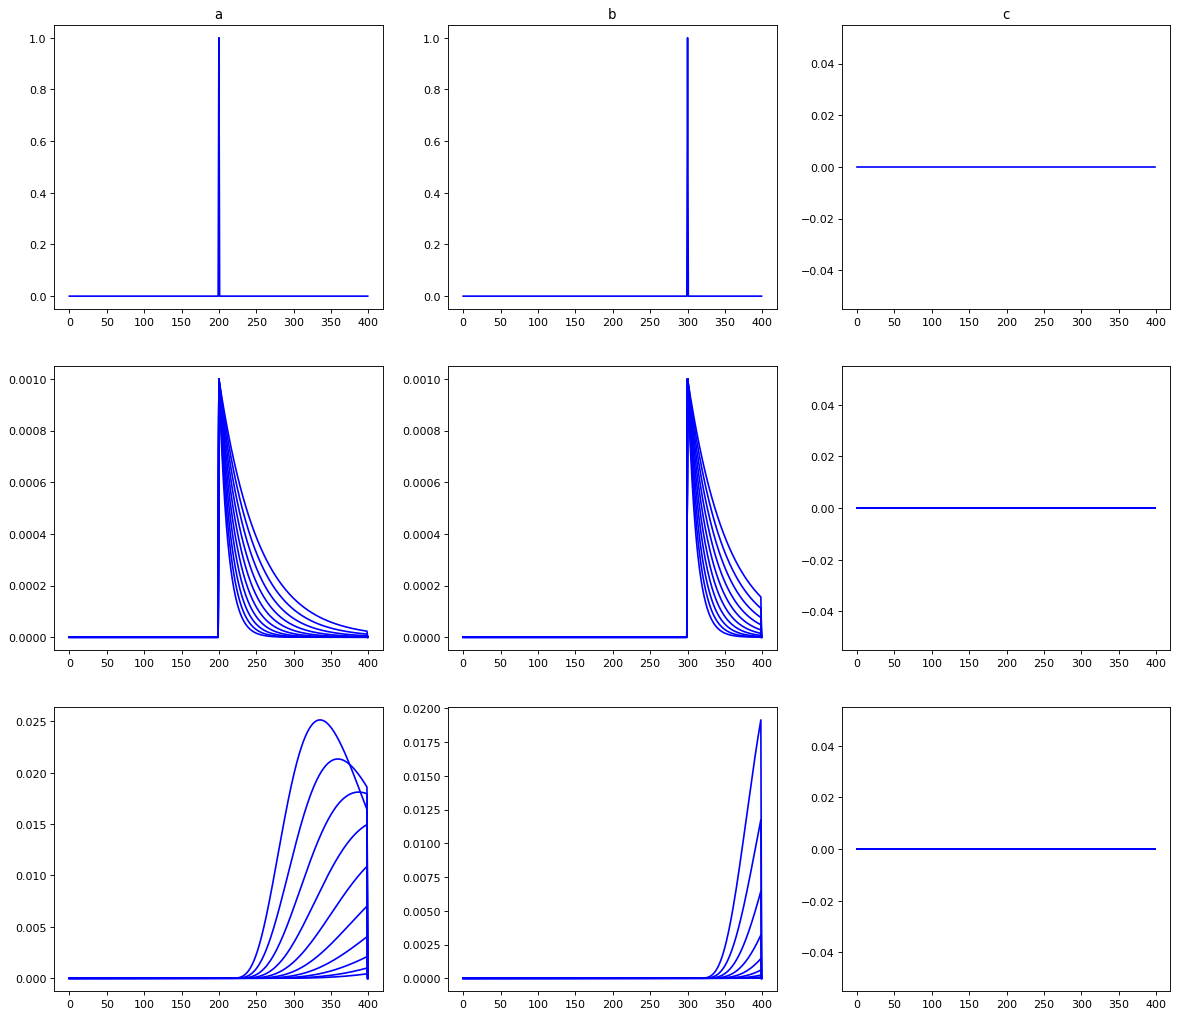

In [13]:
plot_inputs_memory()

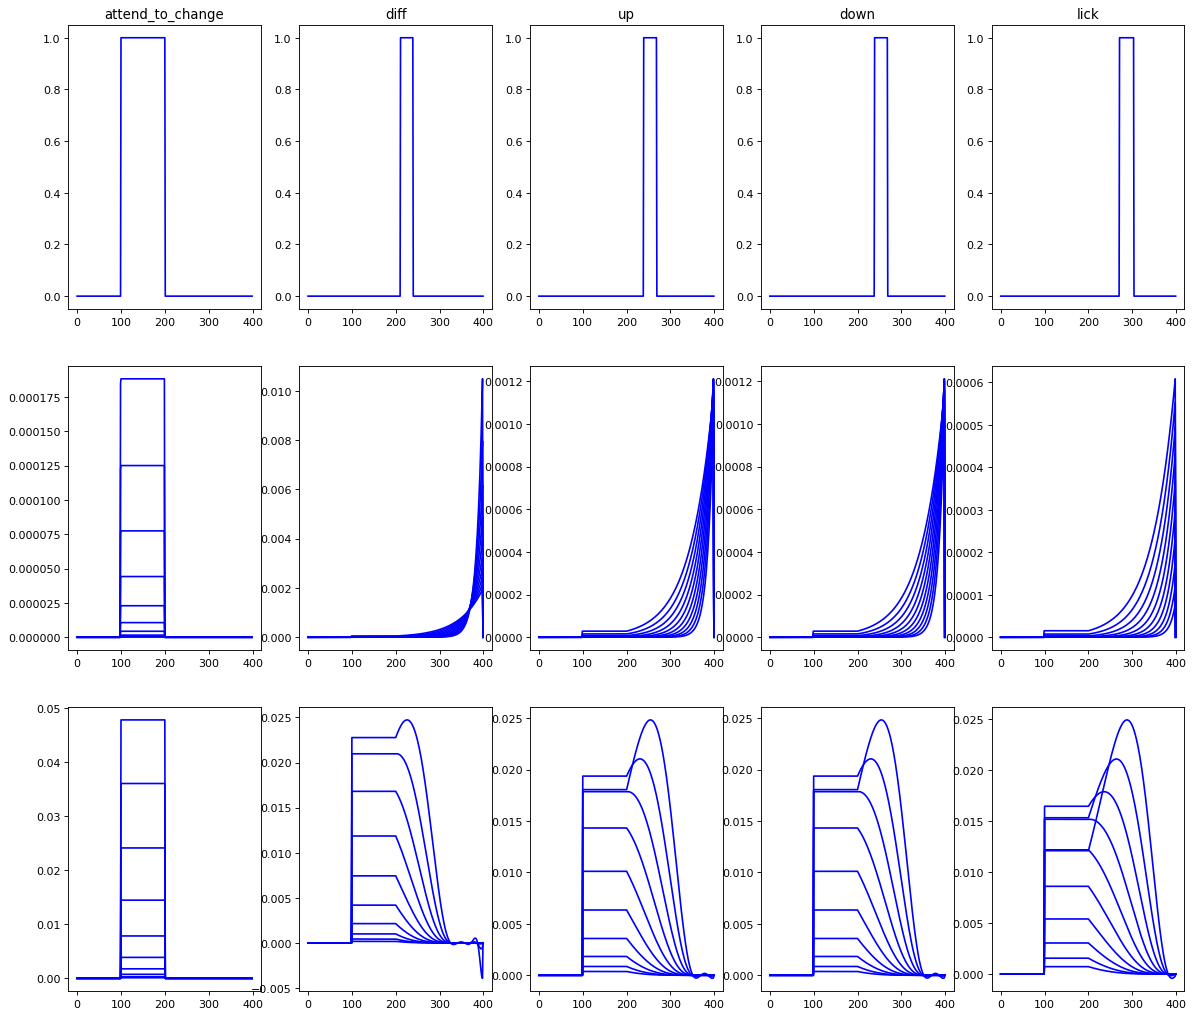

In [14]:
plot_actions_memory()

### Display network structure across time

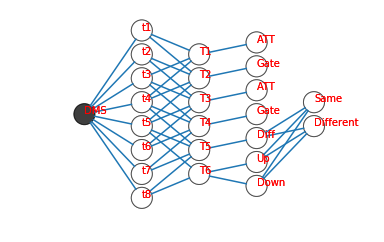

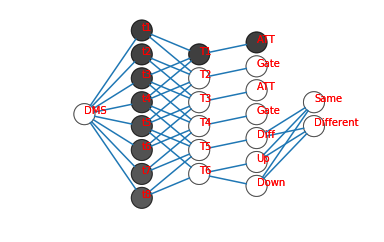

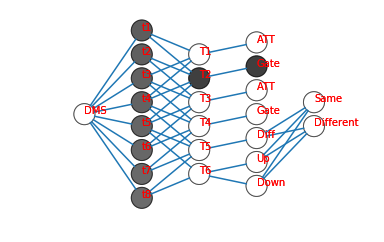

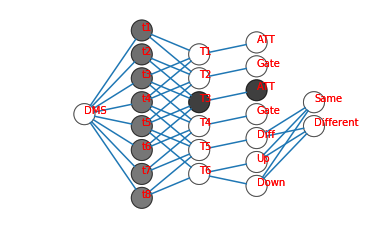

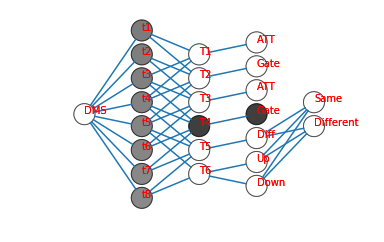

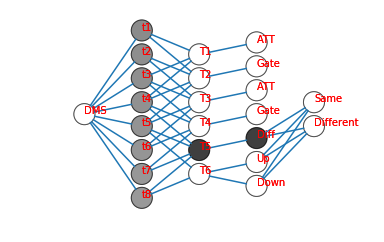

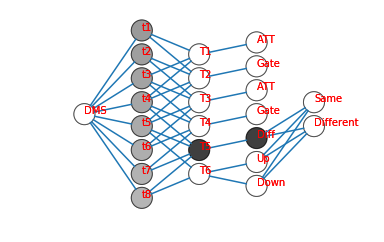

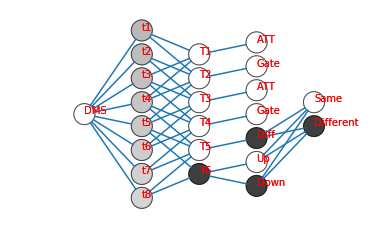

In [15]:
# based on a fork from https://github.com/miloharper/visualise-neural-network
# for a cool example see here: 
# https://medium.com/deep-learning-101/how-to-generate-a-video-of-a-neural-network-learning-in-python-62f5c520e85c


from matplotlib import pyplot
from math import cos, sin, atan
import numpy as np


class Neuron():
    def __init__(self, x, y, text = '', c=[None]):
        if c is [None]:
            c = np.ones(len(self.neurons))
        self.x = y
        self.y = x
        self.text = text
        self.c = c

    def draw(self):
        circle = pyplot.Circle((self.x, self.y), radius=neuron_radius, 
                               edgecolor=(0,0,0), alpha=0.5, facecolor=(self.c,self.c,self.c))
        text_string = pyplot.Text(self.x, self.y, self.text, color='r')
        pyplot.gca().add_patch(circle)
        pyplot.gca().add_artist(text_string)
        
        


class Layer():
    def __init__(self, network, number_of_neurons, test, c=[None]):
        self.previous_layer = self.__get_previous_layer(network)
        self.y = self.__calculate_layer_y_position()
        self.neurons = self.intialise_neurons(number_of_neurons, test, c)

    def intialise_neurons(self, number_of_neurons, text, c=[None]):
        neurons = []
        x = self.__calculate_left_margin_so_layer_is_centered(number_of_neurons)
        for iteration in xrange(number_of_neurons):
            self.text = text[number_of_neurons-iteration-1]
            self.c = c[number_of_neurons-iteration-1]
            neuron = Neuron(x, self.y, self.text, self.c)
            neurons.append(neuron)
            x += horizontal_distance_between_neurons
        return neurons

    def __calculate_left_margin_so_layer_is_centered(self, number_of_neurons):
        return horizontal_distance_between_neurons * (number_of_neurons_in_widest_layer - number_of_neurons) / 2

    def __calculate_layer_y_position(self):
        if self.previous_layer:
            return self.previous_layer.y + vertical_distance_between_layers
        else:
            return 0

    def __get_previous_layer(self, network):
        if len(network.layers) > 0:
            return network.layers[-1]
        else:
            return None

    def line_between_two_neurons(self, neuron1, neuron2):
        angle = atan((neuron2.x - neuron1.x) / float(neuron2.y - neuron1.y))
        x_adjustment = neuron_radius * sin(angle)
        y_adjustment = neuron_radius * cos(angle)
        line = pyplot.Line2D((neuron1.x - x_adjustment, neuron2.x + x_adjustment), 
                             (neuron1.y - y_adjustment, neuron2.y + y_adjustment))
        pyplot.gca().add_line(line)

    def draw(self):
        for neuron in self.neurons:
            neuron.draw()
            #if self.previous_layer:
            #    for previous_layer_neuron in self.previous_layer.neurons:
            #        self.__line_between_two_neurons(neuron, previous_layer_neuron)


class NeuralNetwork():
    def __init__(self):
        self.layers = []

    def add_layer(self, number_of_neurons, text, c=[None]):
        self.layer = Layer(self, number_of_neurons, text, c)
        self.layers.append(self.layer)

    def draw(self):
        for layer in self.layers:
            layer.draw()
            
            

def draw_dms(): 
    
    network.draw()        
    l0 = network.layers[0]
    l1 = network.layers[1]
    l2 = network.layers[2]
    l3 = network.layers[3]
    l4 = network.layers[4]
    
    for neuron in range(len(l1.neurons)/2):
        network.layer.line_between_two_neurons(l0.neurons[0], l1.neurons[neuron])
    for neuron in range(len(l1.neurons)/2):
        network.layer.line_between_two_neurons(l1.neurons[-neuron-1], l0.neurons[0])
    
    for neuron in range(len(l2.neurons)):
        network.layer.line_between_two_neurons(l2.neurons[neuron], l1.neurons[neuron])
    
    for neuron in range(1, len(l2.neurons)):
        network.layer.line_between_two_neurons(l2.neurons[neuron], l1.neurons[neuron-1])
    
    for neuron in range(1, len(l2.neurons)):
        network.layer.line_between_two_neurons(l1.neurons[-neuron], l2.neurons[-neuron])
        
    for neuron in range(1, len(l2.neurons)):
        network.layer.line_between_two_neurons(l1.neurons[-neuron], l2.neurons[-neuron-1])
        
    
    network.layer.line_between_two_neurons(l3.neurons[-1], l2.neurons[-1])
    network.layer.line_between_two_neurons(l3.neurons[-2], l2.neurons[-2])
    network.layer.line_between_two_neurons(l3.neurons[-3], l2.neurons[-3])
    network.layer.line_between_two_neurons(l3.neurons[-4], l2.neurons[-4])
    network.layer.line_between_two_neurons(l3.neurons[-5], l2.neurons[-5])
    network.layer.line_between_two_neurons(l3.neurons[-6], l2.neurons[-6])
    network.layer.line_between_two_neurons(l2.neurons[-6], l3.neurons[-7])
    
    network.layer.line_between_two_neurons(l4.neurons[-1], l3.neurons[-5])
    network.layer.line_between_two_neurons(l4.neurons[-2], l3.neurons[-5])
    network.layer.line_between_two_neurons(l4.neurons[-1], l3.neurons[-6])
    network.layer.line_between_two_neurons(l4.neurons[-1], l3.neurons[-7])
    network.layer.line_between_two_neurons(l4.neurons[-2], l3.neurons[-6])
    network.layer.line_between_two_neurons(l4.neurons[-2], l3.neurons[-7])
    
    
    pyplot.axis('scaled')
    pyplot.axis('off')
    pyplot.xlim(-5, 30)
    #aa = l4.neurons[1]
    #aa.x = 35
    #aa.draw()
    #network = network.layers[0].draw(fill=True)
    network.draw()
    pyplot.show()
        
# set params
vertical_distance_between_layers = 6
horizontal_distance_between_neurons = 2.5
neuron_radius = 1.1#0.5
number_of_neurons_in_widest_layer = 8

%matplotlib inline

# time 1
network = NeuralNetwork()
network.add_layer(1,['DMS'],[0])
network.add_layer(8,['t1','t2','t3','t4','t5','t6','t7','t8'],[1]*8)
network.add_layer(6,['T1','T2','T3','T4','T5','T6'],[1]*6)
network.add_layer(7,['ATT','Gate','ATT','Gate','Diff','Up','Down'],[1]*7)
network.add_layer(2,['Same','Different'],[1]*2)
draw_dms()

# time 2
network = NeuralNetwork()
network.add_layer(1,['DMS'],[1])
network.add_layer(8,['t1','t2','t3','t4','t5','t6','t7','t8'],np.arange(0.,0.16,0.02))
network.add_layer(6,['T1','T2','T3','T4','T5','T6'],[0,1,1,1,1,1])
network.add_layer(7,['ATT','Gate','ATT','Gate','Diff','Up','Down'],[0,1,1,1,1,1,1])
network.add_layer(2,['Same','Different'],[1]*2)
draw_dms()

# time 3
network = NeuralNetwork()
network.add_layer(1,['DMS'],[1])
network.add_layer(8,['t1','t2','t3','t4','t5','t6','t7','t8'],np.arange(0.16,0.24,0.01))
network.add_layer(6,['T1','T2','T3','T4','T5','T6'],[1,0,1,1,1,1])
network.add_layer(7,['ATT','Gate','ATT','Gate','Diff','Up','Down'],[1,0,1,1,1,1,1])
network.add_layer(2,['Same','Different'],[1]*2)
draw_dms()

# time 4
network = NeuralNetwork()
network.add_layer(1,['DMS'],[1])
network.add_layer(8,['t1','t2','t3','t4','t5','t6','t7','t8'],np.arange(0.24,0.32,0.01))
network.add_layer(6,['T1','T2','T3','T4','T5','T6'],[1,1,0,1,1,1])
network.add_layer(7,['ATT','Gate','ATT','Gate','Diff','Up','Down'],[1,1,0,1,1,1,1])
network.add_layer(2,['Same','Different'],[1]*2)
draw_dms()

# time 5
network = NeuralNetwork()
network.add_layer(1,['DMS'],[1])
network.add_layer(8,['t1','t2','t3','t4','t5','t6','t7','t8'],np.arange(0.32,0.4,0.01))
network.add_layer(6,['T1','T2','T3','T4','T5','T6'],[1,1,1,0,1,1])
network.add_layer(7,['ATT','Gate','ATT','Gate','Diff','Up','Down'],[1,1,1,0,1,1,1])
network.add_layer(2,['Same','Different'],[1]*2)
draw_dms()

# time 6
network = NeuralNetwork()
network.add_layer(1,['DMS'],[1])
network.add_layer(8,['t1','t2','t3','t4','t5','t6','t7','t8'],np.arange(0.4,0.48,0.01))
network.add_layer(6,['T1','T2','T3','T4','T5','T6'],[1,1,1,1,0,1])
network.add_layer(7,['ATT','Gate','ATT','Gate','Diff','Up','Down'],[1,1,1,1,0,1,1])
network.add_layer(2,['Same','Different'],[1]*2)
draw_dms()

# time 7
network = NeuralNetwork()
network.add_layer(1,['DMS'],[1])
network.add_layer(8,['t1','t2','t3','t4','t5','t6','t7','t8'],np.arange(0.48,0.64,0.02))
network.add_layer(6,['T1','T2','T3','T4','T5','T6'],[1,1,1,1,0,1])
network.add_layer(7,['ATT','Gate','ATT','Gate','Diff','Up','Down'],[1,1,1,1,0,1,1])
network.add_layer(2,['Same','Different'],[1]*2)
draw_dms()

# time 7
network = NeuralNetwork()
network.add_layer(1,['DMS'],[1])
network.add_layer(8,['t1','t2','t3','t4','t5','t6','t7','t8'],np.arange(0.64,0.96,0.02))
network.add_layer(6,['T1','T2','T3','T4','T5','T6'],[1,1,1,1,1,0])
network.add_layer(7,['ATT','Gate','ATT','Gate','Diff','Up','Down'],[1,1,1,1,0,1,0])
network.add_layer(2,['Same','Different'],[1, 0])
draw_dms()